In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/abalint/projects/phd/Annex82/enfobench-models'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [3]:
data = pd.read_csv("./data/load.csv", parse_dates=['timestamp'], index_col='timestamp')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24407 entries, 2012-09-24 12:30:00 to 2014-02-14 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   24407 non-null  float64
dtypes: float64(1)
memory usage: 381.4 KB


In [5]:
data.head()

,value
timestamp,
2012-09-24 12:30:00,1836.0
2012-09-24 13:00:00,1946.0
2012-09-24 13:30:00,1030.0
2012-09-24 14:00:00,562.0
2012-09-24 14:30:00,560.0


In [6]:
data.tail()

,value
timestamp,
2014-02-14 21:30:00,880.0
2014-02-14 22:00:00,914.0
2014-02-14 22:30:00,830.0
2014-02-14 23:00:00,1884.0
2014-02-14 23:30:00,1578.0


<Axes: xlabel='timestamp'>

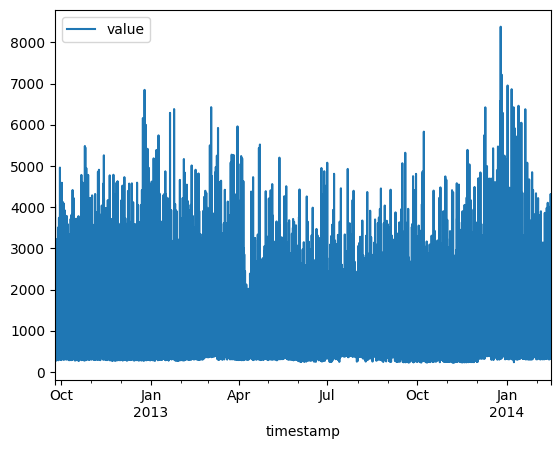

In [7]:
data.plot()

# Create Univariate Dataset

In [8]:
from enfobench.evaluation import Dataset

In [9]:
univariate_dataset = Dataset(target=data.value)

# Create Model

In [10]:
from enfobench.evaluation import ModelInfo, ForecasterType
from enfobench.evaluation.utils import create_forecast_index

class ExampleModel:
    
    def __init__(self, param1: int):
        self.param1 = param1

    def info(self):
        return ModelInfo(
            name="TestModel",
            type=ForecasterType.point,
            params={
                "param1": 1,
            },
        )

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates=None,
        future_covariates=None,
        level=None,
        **kwargs,
    ):
        index = create_forecast_index(history, horizon)
        return pd.DataFrame(
            data={
                "ds": index,
                "yhat": np.full(horizon, fill_value=history["y"].mean()) + self.param1,
            }
        )

# Perform crossvalidation on your model locally

In [11]:
from enfobench.evaluation import cross_validate

In [12]:
model = ExampleModel(1)

In [13]:
crossval_df = cross_validate(
    model, 
    univariate_dataset,
    start_date=pd.Timestamp("2013-07-01T10:00:00"),
    end_date=pd.Timestamp("2013-08-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 424.86it/s]


In [14]:
crossval_df.head()

,ds,yhat,cutoff_date
0,2013-07-01 10:30:00,1106.235189,2013-07-01 10:00:00
1,2013-07-01 11:00:00,1106.235189,2013-07-01 10:00:00
2,2013-07-01 11:30:00,1106.235189,2013-07-01 10:00:00
3,2013-07-01 12:00:00,1106.235189,2013-07-01 10:00:00
4,2013-07-01 12:30:00,1106.235189,2013-07-01 10:00:00


# Evaluate metrics

In [15]:
from enfobench.evaluation import evaluate_metrics_on_forecasts
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [16]:
# Merge the target values with your predictions
forecasts = crossval_df.merge(univariate_dataset.target, on="ds", how="left")

In [17]:
forecasts.head()

,ds,yhat,cutoff_date,y
0,2013-07-01 10:30:00,1106.235189,2013-07-01 10:00:00,590.0
1,2013-07-01 11:00:00,1106.235189,2013-07-01 10:00:00,618.0
2,2013-07-01 11:30:00,1106.235189,2013-07-01 10:00:00,704.0
3,2013-07-01 12:00:00,1106.235189,2013-07-01 10:00:00,698.0
4,2013-07-01 12:30:00,1106.235189,2013-07-01 10:00:00,644.0


In [18]:
metrics = evaluate_metrics_on_forecasts(
    forecasts,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

<Axes: >

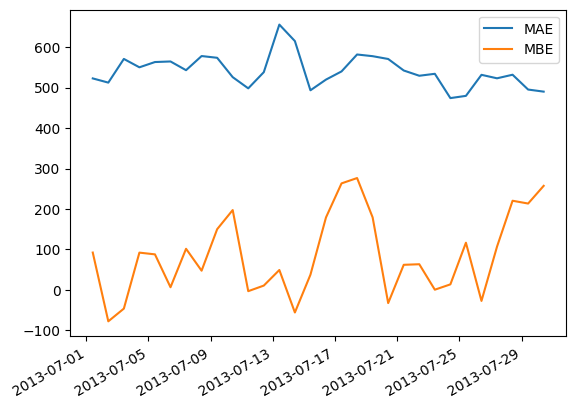

In [19]:
metrics.plot()

# Perform crossvalidation on your model via a server

In [20]:
# Create a client that connects to the forecasting service, such as a local docker container
from enfobench.evaluation import ForecastClient
client = ForecastClient(host="localhost", port=3000)

In [27]:
crossval_df = cross_validate(
    client, 
    univariate_dataset,
    start_date=pd.Timestamp("2013-07-01T10:00:00"),
    end_date=pd.Timestamp("2013-08-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.28it/s]


Merge the target values with the forecasts

In [28]:
forecasts = crossval_df.merge(univariate_dataset.target, on='ds', how='left')

Evaluate the metrics you are interested in.

In [29]:
metrics = evaluate_metrics_on_forecasts(
    forecasts, 
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

<Axes: >

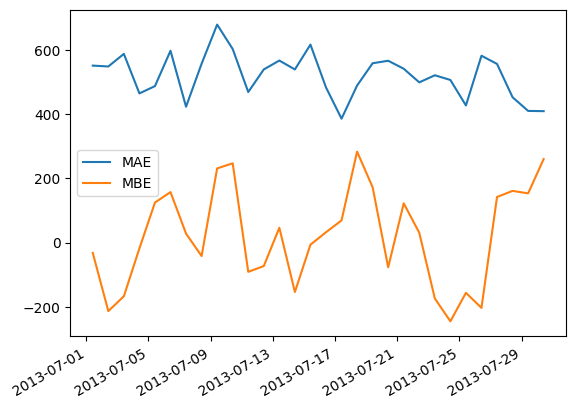

In [30]:
metrics.plot()